# Introdução

Objetivo do projeto é verificar a performance geral das ruas com maior quantia de avaliações, com preços de locação mais caros e preço por tipo de residencia. Criar um modelo de machine learning para prever o preço de locação.

## Localização dos dados:
Seattle Dataset: https://www.kaggle.com/airbnb/seattle/data <br>

## Biblíotecas utilizadas:
Matplotlib, <br>
Pandas, <br>
Seaborn, <br>
Scikit-Learn <br>
RE (Regular Expression)<br>

## Métricas para validação:
R2 squared<br>
Erro quadratico médio (mean_squared_error)

## Modelos de machine learning testados:
LinearRegression<br>
RidgeCV<br>
Ridge<br>
SGDRegressor<br>

## Metodologia para estratificação nos dados:

RepeatedStratifiedKFold

## F

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
import re

In [2]:
sns.set_palette('Accent')
sns.set_style('darkgrid')

## Funções criadas

In [3]:
def transforma_float(df, colunas):
    # Função criada para remoção dos caracteres "$" e "," do nosso dataset,
    # A coluna "price" possui estes valores, então a intenção é remove-los para fazer a conversão para float.

    for i in colunas:
        df[i] = df[i].str.replace('$', '').str.replace(',', '').astype('float')
        
    return df

def testa_modelo(modelo):
    modelo.fit(X_train, y_train)
    ypred = modelo.predict(X_test)
    ypred_train = modelo.predict(X_train)

    r2_test = r2_score(y_test, ypred)
    r2_train = r2_score(y_train, ypred_train)
    mse = mean_squared_error(y_test, ypred)
    
    print('R2 Score: {}, R2 train score: {}, mean_squared_error: {}'.format(r2_test, r2_train, mse))

# Leitura dos dados

In [4]:
seatle_listings = pd.read_csv('..\Data\seatle_listings.csv', encoding='utf-8')

In [5]:
seatle_listings.shape

(3818, 92)

## Entendendo as colunas

Primeiramente iremos verificar quantas colunas possuem todos os valores e depois verificar as que mais possuem dados faltantes.

In [6]:
# 47 colunas possuem todos os valores preenchidos
len(seatle_listings.columns[seatle_listings.isnull().mean() == 0])

47

In [7]:
# Colunas com 50% dos valores faltantes
seatle_listings.columns[seatle_listings.isnull().mean() > .50]

Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')

In [8]:
# colunas com 75% dos valores faltantes.
seatle_listings.columns[seatle_listings.isnull().mean() > .75]

Index(['square_feet', 'license'], dtype='object')

#### Drop de colunas com todos valores nan e none

In [9]:
# Todos os valores aqui inseridos são NaN, então serão dropados.
seatle_listings['license'].unique()

array([nan])

In [10]:
seatle_listings.dropna(how = 'all', axis = 1, inplace = True)

In [11]:
seatle_listings.drop('experiences_offered', axis = 1, inplace = True)

#### Verificação de colunas categoricas

In [12]:
# Com este set iremos verificar colunas que possivelmente são numéricas e estão listadas como str
set(seatle_listings.select_dtypes('object').columns)

{'amenities',
 'bed_type',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'country',
 'country_code',
 'description',
 'extra_people',
 'first_review',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_url',
 'host_verifications',
 'instant_bookable',
 'is_location_exact',
 'jurisdiction_names',
 'last_review',
 'last_scraped',
 'listing_url',
 'market',
 'medium_url',
 'monthly_price',
 'name',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'notes',
 'picture_url',
 'price',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'security_deposit',
 'smart_locat

In [13]:
# Verificando possiveis variaveis para agrupamento, possivelmente o CEP será o escolhido, pois o percentual de itens faltantes é muito baixo.
seatle_listings['zipcode'].isnull().value_counts(normalize = True)

False    0.998167
True     0.001833
Name: zipcode, dtype: float64

In [14]:
# Pela rua também é uma ótima opção, pois todos os valores estão preenchidos
seatle_listings['street'].isnull().value_counts()

False    3818
Name: street, dtype: int64

#### Conversão para valores numéricos

In [15]:
# Colunas identificadas como valores numéricos foram convertidas. 
transforma_float(seatle_listings, seatle_listings[['extra_people', 'cleaning_fee', 'monthly_price', 'price', 'weekly_price', 'security_deposit']])

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,...,9.0,10.0,f,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,...,10.0,10.0,f,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,...,10.0,10.0,f,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,...,NaN,NaN,f,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,...,9.0,9.0,f,WASHINGTON,f,strict,f,f,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,We're located near lots of family fun. Woodlan...,NaN,...,10.0,8.0,f,WASHINGTON,f,strict,f,f,8,0.30
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,The neighborhood is a quiet oasis that is clos...,This is a basement apartment in a newer reside...,...,10.0,10.0,f,WASHINGTON,f,moderate,f,f,1,2.00
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",NaN,NaN,...,NaN,NaN,f,WASHINGTON,f,moderate,f,f,1,NaN
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,Madison Park offers a peaceful slow pace upsca...,NaN,...,NaN,NaN,f,WASHINGTON,f,moderate,f,f,1,NaN


#### Seleção valores a serem inseridos na coluna de valor semanal

Preferi utilizar desta metodologia do que remover as colunas, assim ainda teria um valor para trabalhar e nao "jogaria fora" informações do dataset.

In [16]:
id_price = seatle_listings.groupby(['id'])['price'].sum()

In [17]:
seatle_listings['id'][seatle_listings['weekly_price'].isnull() == True].map(id_price * 7)

0        595.0
2       6825.0
4       3150.0
13      1155.0
14      3227.0
         ...  
3811     455.0
3813    2513.0
3814     553.0
3816     693.0
3817     609.0
Name: id, Length: 1809, dtype: float64

In [18]:
# Parte utilizada para adicionar o valor na coluna weekly_price
# Decidi seguir o caminho no qual foi selecionado o valor da diária * 7 para chegar ao valor semanal
seatle_listings.loc[:, 'weekly_price'][seatle_listings['weekly_price'].isnull()] = (seatle_listings['id'][seatle_listings['weekly_price'].isnull() == True]
                                                                                    .map(id_price * 7))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


O processo acima funcionou. No fim das contas, queremos o maximo de valores preenchidos, então foi o metodo que achei mais adequado para preencher os dados de uma forma "real". Nao estou levando em consideracoes se o dono do local pode aplicar descontos em pacotes semanais/mensais. A intenção é verificar o desempenho semanal e mensal dos estados e no fim, criar um modelo de regressão para prever o possivel valor de uma diária.

Usaremos o mesmo processo para preencher os valores mensais.

In [19]:
# 60% dos dados nulos, iremos preencher os mesmos com os valores semanais x4
seatle_listings.loc[:, 'monthly_price'].isnull().value_counts(normalize = True)

True     0.602672
False    0.397328
Name: monthly_price, dtype: float64

In [20]:
wk_price = seatle_listings.groupby(['id'])['weekly_price'].sum()
seatle_listings.loc[:, 'monthly_price'][seatle_listings['monthly_price'].isnull()] = (seatle_listings['id'][seatle_listings['monthly_price'].isnull() == True]
                                                                                    .map(wk_price * 4))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
seatle_listings['monthly_price'].isnull().value_counts(normalize=True)

False    1.0
Name: monthly_price, dtype: float64

In [22]:
# Agora, seguindo para nossa ultima variável numérica (de valores), para taxa de limpeza, os valores nulos serão preenchidos com 0
seatle_listings['cleaning_fee'].fillna(0, inplace = True)

In [23]:
# verificalçao de variaveis que ainda possuem valores nulos
seatle_listings.columns[seatle_listings.isnull().mean()>0]

Index(['summary', 'space', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'zipcode', 'property_type', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'security_deposit', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [24]:
seatle_listings['review_scores_value'].isnull().value_counts(normalize=True)

False    0.828182
True     0.171818
Name: review_scores_value, dtype: float64

In [25]:
# iremos dropar os codigos postais que nao estao presentes, para que possamos utilizar como mapeador de review
seatle_listings.dropna(subset=['zipcode'], axis = 0, inplace = True)

In [26]:
review_scores_value_per_zipcode = round(seatle_listings.groupby(['zipcode'])['review_scores_value'].mean(), 2)

In [27]:
# Utilizado para fazer o preenchimento dos valores nulos da variavel review_score_value
# a metodologia foi utilizar a média das avaliações de X codigo postal
seatle_listings.loc[:, 'review_scores_value'][seatle_listings['review_scores_value'].isnull() == True] = (seatle_listings['zipcode']
                                                                                                          .map(review_scores_value_per_zipcode))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
# variavel que representa o tempo de resposta, se responde dentro de 1 hora, 1 dia, etc... Iremos considera-la categoria e recolocar
# seus valores para numericos representando suas categorias (valores nan serão preenchidos como -1)
seatle_listings['host_response_time'] = seatle_listings['host_response_time'].astype('category').cat.codes

#### Dropando algumas colunas categoricas.

Os critérios utilizados para o drop das colunas foram:

Colunas que informam o mesmo valor repetidamente, isso atrapalha na capacidade do nosso futuro modelo de lidar com informacoes generalizadas,
URL's e imagens. (Também foram removidas colunas que possuiam valores iguais)

Minha primeira ideia era remover colunas que continham mais de 10 caracteres em seus valores, mas nao segui com esta ideia. Preferi olhar cada coluna destas categoricas e decidir qual seria de maior relevancia ou não.

In [29]:
# selecao de colunas a serem dropadas
cat_cols=seatle_listings.select_dtypes('object').columns

In [30]:
drop_list = ['listing_url', 'last_scraped', 'name', 'space', 'notes', 'transit',
            'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
            'host_url', 'host_name', 'host_since', 'host_about',
            'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
            'host_has_profile_pic', 'neighbourhood', 'city', 'state', 'market', 
            'smart_location', 'country_code', 'country',
            'has_availability', 'first_review', 'last_review', 
            'requires_license', 'jurisdiction_names', 'summary', 'host_id', 'host_acceptance_rate',
            'id', 'scrape_id', 'host_verifications']

In [31]:
# no fim das contas, conseguimos dar uma balanceada nas variaveis categoricas e quantitativas.
len(cat_cols) - len(drop_list)

18

In [32]:
len(seatle_listings.select_dtypes('float').columns)

22

In [33]:
seatle_listings.drop(drop_list, axis = 1, inplace = True)

In [34]:
# mais uma correção de uma coluna que deveria ser numérica e estava como string
seatle_listings['host_response_rate'] = seatle_listings['host_response_rate'].str.replace('%', '').astype('float')

#### extração de palavras das descrições

Para que possamos utilizar as colunas de descrição e de informações gerais da vizinhanca, selecionei algumas palavras chave.<br>
O objetivo é contar quantas vezes as palavras chave aparecem, para que tenhamos alguma informação da coluna para usar futuramente (a mesma metodologia será aplicada na descrição)

In [35]:
word_list = ['charming', 'beautifull', 'spectacular', 'cozy', 'comfortable',
            'wondeful', 'quiet', 'view', 'close', 'gorgeous', 'pets', 'cat', 'dog',
            'family', 'calm', 'peacefull', 'safe', 'police', 'bus', 'uber', 'taxi']

In [36]:
# Metodologia abaixo encontrada em stack overflow
# Link: https://stackoverflow.com/questions/62619082/check-if-column-in-data-frame-contain-any-word-from-a-list-adding-count-pytho
search = re.compile("\\b%s\\b" % "\\b|\\b".join(word_list), flags = re.IGNORECASE)

In [37]:
seatle_listings['description'] = seatle_listings['description'].str.findall(search).apply(len)
# vamos dar um fillna com o valor 0 na variavel neighborhood overview, pois como iremos transforma-la em numerica, o 0 irá preencher os valores nan
seatle_listings.loc[:, 'neighborhood_overview'][seatle_listings['neighborhood_overview'].isnull()==False] = (
    seatle_listings.loc[:, 'neighborhood_overview'][seatle_listings['neighborhood_overview'].isnull()==False].str.findall(search).apply(len))

C:\Users\Kaiqu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [38]:
seatle_listings['neighborhood_overview'].fillna(int(0), inplace = True)
seatle_listings['neighborhood_overview'] = seatle_listings['neighborhood_overview'].astype('int')

In [39]:
# hosts que nao possuem tempo de resposta serao classificados como tempo 0 também
seatle_listings['host_response_rate'].fillna(0, inplace =True)

In [40]:
# verificacao das colunas que ainda possuem nulos.
seatle_listings.isnull().mean()

description                         0.000000
neighborhood_overview               0.000000
host_location                       0.002099
host_response_time                  0.000000
host_response_rate                  0.000000
host_is_superhost                   0.000525
host_listings_count                 0.000525
host_total_listings_count           0.000525
host_identity_verified              0.000525
street                              0.000000
neighbourhood_cleansed              0.000000
neighbourhood_group_cleansed        0.000000
zipcode                             0.000000
latitude                            0.000000
longitude                           0.000000
is_location_exact                   0.000000
property_type                       0.000262
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.004198
bedrooms                            0.001574
beds                                0.000262
bed_type  

In [41]:
seatle_listings.dropna(subset = ['host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count'], axis = 0, inplace = True)
seatle_listings.dropna(subset = ['beds', 'bathrooms', 'bathrooms', 'bedrooms'], axis = 0, inplace = True)

In [42]:
seatle_listings.drop(columns='square_feet', inplace = True)

In [43]:
seatle_listings['reviews_per_month'].fillna(0, inplace = True)
seatle_listings['security_deposit'].fillna(0, inplace = True)

In [45]:
# não posso substituir nenhum destes valores, nem preenche-los, pois sao avaliações importantes, entao iremos dropar os nulos
seatle_listings[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location']]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,95.0,10.0,10.0,10.0,10.0,9.0
1,96.0,10.0,10.0,10.0,10.0,10.0
2,97.0,10.0,10.0,10.0,10.0,10.0
3,NaN,NaN,NaN,NaN,NaN,NaN
4,92.0,9.0,9.0,10.0,10.0,9.0
...,...,...,...,...,...,...
3813,80.0,8.0,10.0,4.0,8.0,10.0
3814,100.0,10.0,10.0,10.0,10.0,10.0
3815,NaN,NaN,NaN,NaN,NaN,NaN
3816,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
seatle_listings.dropna(axis = 0, how = 'any', inplace = True)

#### Extração da rua

In [47]:
# antes de tudo, vamos resetar o indice
seatle_listings.reset_index(inplace = True, drop=True)
seatle_listings['street'] = seatle_listings['street'].str.rsplit(',').str[0]

In [48]:
cep=seatle_listings['zipcode'].unique()[10]

In [49]:
# corrigindo cep estranho
seatle_listings.query('zipcode in @cep')

,description,neighborhood_overview,host_location,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,street,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
715,1,0,US,1,60.0,f,3.0,3.0,t,14th Ave,...,10.0,10.0,10.0,10.0,f,flexible,f,f,3,1.0


In [50]:
seatle_listings.loc[715, 'zipcode'] = seatle_listings.loc[715, 'zipcode'][3:]

# Verificação de performance

### Quais ruas possuem os maiores preços de alocação?

Para responder esta pergunta, iremos seguir com um agrupamento por rua e selecionar a média do preço. Iremos tratar as 10 primeiras ruas com os maiores preços para que em outra visualizações possamos identificar (com base nas metodologias selecionadas) se as mais caras possuem mais avaliações, etc...

In [51]:
media_preço_rua = seatle_listings.groupby(['street'])['price'].mean().sort_values(ascending = False).head(10)

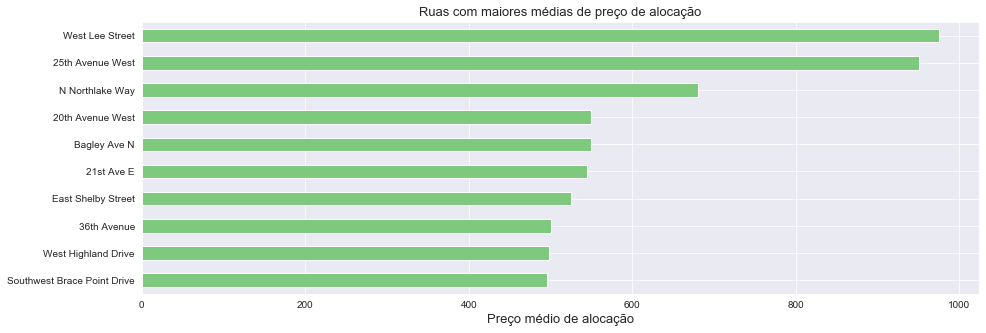

In [52]:
ax = media_preço_rua.sort_values(ascending = True).plot(kind = 'barh', figsize = (15,5))
ax.set_ylabel('')
ax.set_title('Ruas com maiores médias de preço de alocação', fontsize = 13)
ax.set_xlabel('Preço médio de alocação', fontsize = 13);

### Quais ruas que mais utilizaram as palavras chave?

Como determinei na tratativa dos dados, algumas palavras chave foram selecionadas e foi adicionado a contagem em que elas aparecem nas descrições, então utilizaremos isso para verificar as ruas que mais utilizaram estas palavras chave.

In [53]:
rua_palavra_chave = seatle_listings.groupby(['street'])['description'].sum().sort_values(ascending = False).head(10)

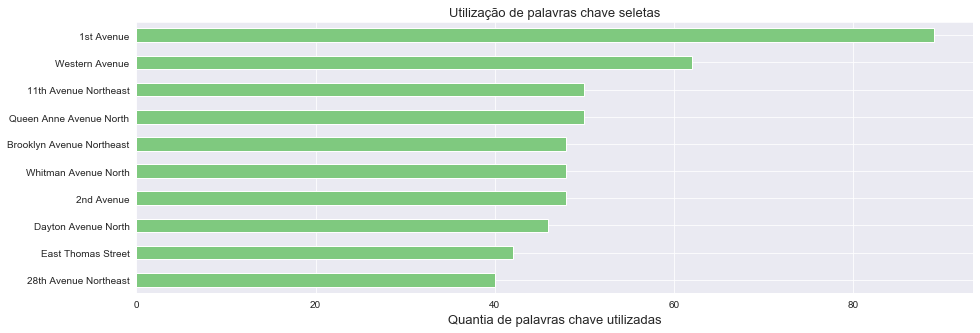

In [54]:
ax = rua_palavra_chave.sort_values(ascending=True).plot(kind='barh', figsize=(15,5))
ax.set_ylabel('')
ax.set_title('Utilização de palavras chave seletas', fontsize = 13)
ax.set_xlabel('Quantia de palavras chave utilizadas', fontsize = 13);

### Quais ruas com maiores contagens de avaliações?

Com base na visualização anterior, minha ideia é conferir se as ruas com maiores medias de preço, possuem as maiores quantias de avaliações de usuarios tambem, e possivelmente justificando os altos preços devido a alta demanda de locação.

In [55]:
aval_count = seatle_listings.groupby('street')['review_scores_value'].count().sort_values(ascending = False).head(10)

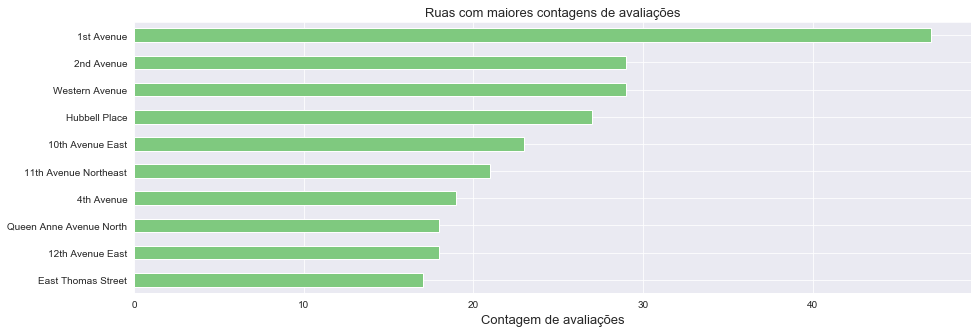

In [56]:
ax = aval_count.sort_values(ascending = True).plot(kind ='barh', figsize=(15,5))
ax.set_ylabel('')
ax.set_title('Ruas com maiores contagens de avaliações', fontsize = 13)
ax.set_xlabel('Contagem de avaliações', fontsize = 13);

E como resultado podemos ver que na verdade, as ruas que mais utilizaram as palavras chave selecionadas são as que mais possuem avaliações (a maioria pelo menos), e não as que possuem maiores preços.

### Qual a média de valor cobrado por tipo de propriedade?

Intenção desta visualização, é tirar uma base do quanto é cobrado em média por tipo de residencia

In [57]:
media_por_propriedade = seatle_listings.groupby(['property_type'])['price'].mean().sort_values()

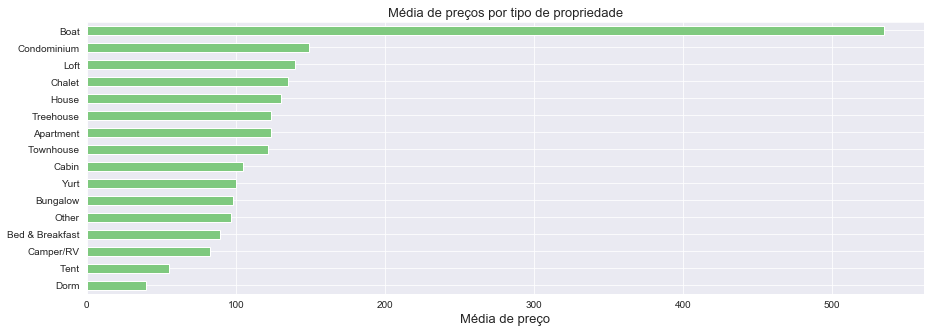

In [58]:
ax = media_por_propriedade.sort_values(ascending = True).plot(kind='barh', figsize=(15,5))
ax.set_title('Média de preços por tipo de propriedade', fontsize=13)
ax.set_ylabel('')
ax.set_xlabel('Média de preço', fontsize=13);

### Quais propriedades possuem mais avaliações?

In [59]:
count_prop = seatle_listings.groupby(['property_type'])['review_scores_value'].count().sort_values(ascending = True)

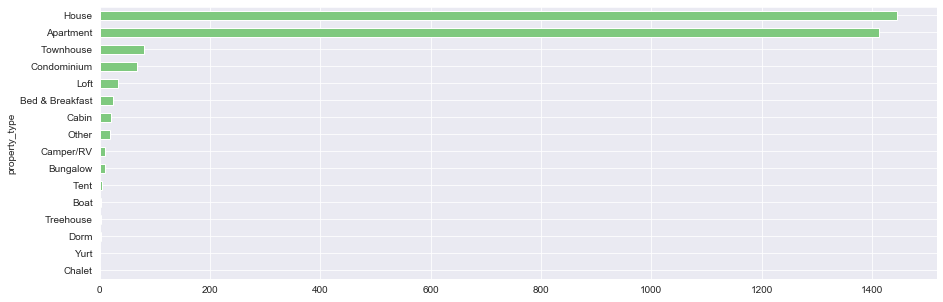

In [60]:
count_prop.plot(kind = 'barh', figsize=(15,5))

## Instanciamento modelo linear

#### Teste I:
Verificação das métricas dos modelos sem estratificação nos dados

In [61]:
from sklearn.linear_model import Ridge

In [62]:
new_cat_cols = seatle_listings.select_dtypes('object').columns
for col in new_cat_cols:
    seatle_listings = pd.concat([seatle_listings.drop(col, axis = 1), pd.get_dummies(seatle_listings[col], drop_first=True, prefix=col)], axis = 1) 

In [63]:
linear = LinearRegression(normalize=True)
ridge = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge2 = Ridge()

In [64]:
X = seatle_listings.drop('price', axis = 1)
y = seatle_listings['price']

In [65]:
# separação de nossos dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
testa_modelo(linear)

R2 Score: -2.2614168658872584e+23, R2 train score: 0.998519551834112, mean_squared_error: 1.8085687096697715e+27


In [67]:
testa_modelo(ridge)

R2 Score: 0.8376787346266902, R2 train score: 0.9925329015615978, mean_squared_error: 1298.164729805315


In [68]:
testa_modelo(sgd)

R2 Score: -9.193733032806853e+25, R2 train score: -8.420806091179547e+26, mean_squared_error: 7.352690315090628e+29


In [69]:
testa_modelo(ridge2)

R2 Score: 0.9397725711445206, R2 train score: 0.9881932587489705, mean_squared_error: 481.6690143908779


O modelo que usa uma leve stratificação se deu um pouco melhor, então irei estratificar os dados para depois instanciar o modelo

#### Teste II: 
Dados estratificados

In [70]:
cv = RepeatedStratifiedKFold()
cv.get_n_splits(X,y)

50

In [71]:
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.T[train_index], X.T[test_index]
    y_train, y_test = y[train_index], y[test_index]

C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

In [72]:
X_train, X_test = X_train.T, X_test.T

In [73]:
linear = LinearRegression(normalize=True)
ridge = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge2 = Ridge()

In [74]:
testa_modelo(linear)

R2 Score: -6.435784632553918e+23, R2 train score: 0.9974066276634447, mean_squared_error: 5.014197775806784e+27


In [75]:
testa_modelo(ridge)

R2 Score: 0.816993880556205, R2 train score: 0.9940781925310141, mean_squared_error: 1425.8228475087485


In [76]:
testa_modelo(sgd)

R2 Score: -3.303232731953179e+28, R2 train score: -1.8184075463728914e+29, mean_squared_error: 2.573588639643316e+32


In [77]:
testa_modelo(ridge2)

R2 Score: 0.9468752590468897, R2 train score: 0.9879100244725186, mean_squared_error: 413.9012927498939


Verificando a distribuição da nossa variavel y, ela é assimetrica a esquerda.<br>
Entao para tentar deixar com uma distribuição normal, irei usar seu logaritmo.

#### Teste III:
Utilização de logarítimo da variavel y para adquirir uma distribuição normal

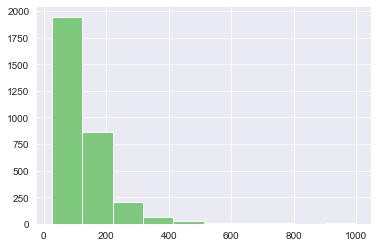

In [78]:
y.hist()

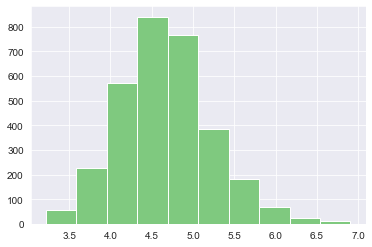

In [79]:
# para reverter a seu estado original, basta utilizar np.exp()
y_log = np.log(y)
y_log.hist()

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

linear = LinearRegression(normalize=True)
ridge = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge2 = Ridge()

In [81]:
testa_modelo(linear)

R2 Score: -4.211979988711582e+23, R2 train score: 0.9971553614859504, mean_squared_error: 1.30698771622944e+23


In [82]:
testa_modelo(ridge)

R2 Score: 0.7989374210380171, R2 train score: 0.996190640592043, mean_squared_error: 0.062390211159837


In [83]:
testa_modelo(sgd)

R2 Score: -3.639511840423121e+32, R2 train score: -4.500642361380807e+32, mean_squared_error: 1.1293494464012627e+32


In [84]:
testa_modelo(ridge2)

R2 Score: 0.8693280173635368, R2 train score: 0.9796807514732234, mean_squared_error: 0.0405478365564236


Os modelos performaram um pouco melhor, irei testar com dados estratificados agora para checar se há alguma melhora

#### Teste IV: 
Utilizando logaritmo e dados estratificados

In [85]:
np.random.seed(42)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.T[train_index], X.T[test_index]
    y_train, y_test = y_log[train_index], y_log[test_index]

C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Kaiqu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least

In [86]:
X_train, X_test = X_train.T, X_test.T

In [87]:
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [151]:
linear = LinearRegression(normalize=True)
ridge = RidgeCV(normalize=True)
sgd = SGDRegressor()
ridge2 = Ridge()

In [152]:
testa_modelo(linear)

R2 Score: -2.549680399215677e+24, R2 train score: 0.979776262335905, mean_squared_error: 7.771126521526088e+23


In [153]:
testa_modelo(ridge)

R2 Score: 0.7891321772367623, R2 train score: 0.9953665796512651, mean_squared_error: 0.06427003676680194


In [154]:
testa_modelo(sgd)

R2 Score: -5.848840375874313e+31, R2 train score: -6.87647493132639e+31, mean_squared_error: 1.7826578805371557e+31


In [155]:
# winner!
testa_modelo(ridge2)

R2 Score: 0.8663619214605484, R2 train score: 0.9793070240792004, mean_squared_error: 0.040731317413083785


#### Verificação de alguns resultados

In [156]:
ridge2.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [157]:
# Resultado com predict
np.exp(ridge2.predict(X_test.iloc[:10, :]))

array([ 91.43929108,  90.53060899, 160.59895607, 130.97366076,
        66.48100486, 116.69156436, 874.17584335, 127.56073374,
       132.20963495,  70.67083575])

In [158]:
# Resultado original
np.exp(y_test[:10])

0    120.0
1     90.0
2    165.0
3    109.0
4     66.0
5    110.0
6    600.0
7    150.0
8    130.0
9     70.0
Name: price, dtype: float64

# Conclusões

Já gostaria de deixar informado que de forma alguma as metodologias que utilizei são completamente corretas, mas foram as que achei melhor de utilizar.

Durante o processo para ajustar os dados, foi de longe o mais complicado, pois os dados possuem muitas informações a serem utilizadas porém me foquei nas que considerei mais uteis para esta analise. Busquei algumas resposta no stackoverflow por nao tinha a menor ideia de como prosseguir, e de certa forma, imagino que no final deu tudo certo. Sem contar também a contagem excessiva de valores NaN.

Durante o processo da visualização, vimos no começo as ruas com maior preço de alocação, vimos as ruas que mais utilizaram as palavras chave que definimos previamente, as que mais possuem avaliações, o mais interessante, é que boa parte das ruas com mais utilização das palavras chave foram as que mais receberam avaliações! Então podemos, de certa forma, dizer que a descrição utilizando certas palavras podem ajudar a o local ser alocado. Vimos também os tipos de "residencia" que estavam para locação, fiquei impressionado que até barcos são alocados pelo airbnb, tambem verificamos os tipos de propriedade que mais possuem avaliações que por sua maioria foram casa e apartamento e o preço médio destas propriedades.

Na parte do nosso modelo de machine learning, foi muito complicada e me levou alguns dias para chegar no resultado atual.<br>
Inicialmente, iria fazer apenas com o modelo `LinearRegression` que foi visto em curso, porém suas métricas foram muito ruins (Isto é devido a forma como meus dados ficaram em seu estado final, nao por causa do modelo), então comecei a procurar outros modelos que poderia testar. Então encontrei o `RidgeCV`, selecionei ele pois modelos que lidam com validação cruzada tendem a generalizar melhor quando ajustado aos dados (Como o processo para verificação dos dados, me tomou muito tempo, fiquei sem ideias do que fazer para tentar alterar o resultado com base nos dados, então foquei em testar outros modelos), apos os testes com o RidgeCV serem *levemente melhores*, tentei adicionar mais alguns modelos (incluindo o modelo `Ridge`, que foi o que performou melhor). <br>

Apos alguns leves testes, para verificar o erro quadratico médio e o R2 score, como o modelo RidgeCV tinha performado um pouco melhor, pensei em fazer a _estratificação nos dados_ e ver o comportamento dos outros modelos(que não mudaram muita coisa), e o mais interessante é que fora a validação cruzada do proprio RidgeCV, com os dados estratificados *ele performou um pouco melhor*. Foi neste momento que decidi testar o modelo Ridge, com dados estratificados e sem, e sua performance foi superior a todos os outros modelos, porém o erro quadratico ainda estava me intrigando, pois estava com um valor que eu não estava acostumado a ver.<br>

Após os testes no modelo Ridge, lembrei de ter visto em algum lugar, que quando a distribuição da variavel alvo não é normal, o modelo pode ficar com problemas e ter resultados diversos, então lembrei que em alguns casos, ao invés de utilizar o valor real, poderiamos utilizar o valor logaritimico para tentar adquirir uma *distribuição normal*, e foi o que ocorreu em nosso caso (Não sei se esta foi a melhor decisão a ser tomada, mas me parece que sim com base no meu conhecimento limitado em machine learning). Após as alterações feitas nos dados de treino e teste, a metodologia Ridge chego muito perto dos resultados esperados, o modelo não chegou a receber um overfit, com um valor R2 aceitável e um erro quadratico abaixo de 0.05 (no limite, mas abaixo), e foi com este resultado que decidi conceder que este modelo seria apropriado para previsões com os dados que tinha escolhido.